# Loading Libraries

In [121]:
import json
import pandas as pd
import numpy as np
from datetime import datetime
from pandasql import sqldf 

# Reading Data

In [122]:
user = pd.read_json('users.json', lines=True)
receipt = pd.read_json('receipts.json', lines=True)
brand = pd.read_json('brands.json', lines=True)

# Flatten Date and Non-Date columns

In [123]:
# Function Definitions to flatten date and non date columns
def flatten_1 (df,col):
    df[col] = pd.json_normalize(df[col])
    return df

def flatten_2(df, col):
  flatten_data=[]
  for x in df[col].values:
    if type(x) == float:
      flatten_data.append(np.nan)
    else:
      flatten_data.append(pd.to_datetime(datetime.fromtimestamp(x['$date'] // 1e3)))
  df[col] = flatten_data
  return df

# Flattening date and non date columns of user table
user_nondate_columns = ['_id']
user_date_columns = ['createdDate','lastLogin']
for j in user_nondate_columns:
    user = flatten_1(user,j)
for k in user_date_columns:
  user = flatten_2(user, k)

# Flattening date and non date columns of receipt table
receipt_nondate_columns = ['_id']
receipt_date_columns = ['createDate', 'dateScanned', 'finishedDate', 'modifyDate', 'pointsAwardedDate', 'purchaseDate']
for j in receipt_nondate_columns:
    receipt = flatten_1(receipt,j)
for k in receipt_date_columns:
  receipt = flatten_2(receipt, k)

# Flattening date and non date columns of brand table
brand_nondate_columns = ['_id']
for j in brand_nondate_columns:
    brand = flatten_1(brand,j)  

# Flatten Special Columns

In [124]:
#1) User table is all good.


#2) Flattening special columns in receipt data frame
item = pd.DataFrame()
item['_id'] = ''
for i in range(len(receipt['rewardsReceiptItemList'])):
  x = receipt['rewardsReceiptItemList'].iloc[i]
  if type(x) != float:
    for y in x:
      item = pd.concat([item, pd.DataFrame.from_dict(y, orient='index').transpose()])
      item['_id'] = item['_id'].fillna(receipt.iloc[i]['_id'])     
receipt = receipt.drop("rewardsReceiptItemList" ,axis= 1)


#3) Flattening special columns in brand data frame
cpg = pd.DataFrame()
key=[]
oid=[]
ref=[]
for i in range(len(brand['cpg'])):
    x = brand['cpg'].iloc[i]
    key.append(brand.iloc[i]['_id'])
    ref.append(brand['cpg'][i]['$ref'])
    oid.append(brand['cpg'][i]['$id']['$oid'])
   
    
cpg['id'] = key
cpg['ref'] = ref
cpg['oid'] = oid

brand = brand.merge(cpg, left_on='_id', right_on='id', how='inner')
brand = brand.drop(['id','cpg','ref'], axis=1)

# Data Sanity Checks

## 1) Initial Checks

In [130]:
# Check 1
instance = lambda q: sqldf(q, globals())
brand1 = '''select distinct category,categoryCode from brand'''
instance(brand1)

,category,categoryCode
0,Baking,BAKING
1,Beverages,BEVERAGES
2,Candy & Sweets,CANDY_AND_SWEETS
3,Condiments & Sauces,None
4,Canned Goods & Soups,None
5,Baking,None
6,None,None
7,Magazines,None
8,Breakfast & Cereal,None
9,Beer Wine Spirits,None


In [131]:
#The categoryCode has same information or less information compared to the category column. Hence it is useless.
brand = brand.drop('categoryCode', axis=1)
brand.head()

,_id,barcode,category,name,topBrand,brandCode,oid
0,601ac115be37ce2ead437551,511111019862,Baking,test brand @1612366101024,0.0,NaN,601ac114be37ce2ead437550
1,601c5460be37ce2ead43755f,511111519928,Beverages,Starbucks,0.0,STARBUCKS,5332f5fbe4b03c9a25efd0ba
2,601ac142be37ce2ead43755d,511111819905,Baking,test brand @1612366146176,0.0,TEST BRANDCODE @1612366146176,601ac142be37ce2ead437559
3,601ac142be37ce2ead43755a,511111519874,Baking,test brand @1612366146051,0.0,TEST BRANDCODE @1612366146051,601ac142be37ce2ead437559
4,601ac142be37ce2ead43755e,511111319917,Candy & Sweets,test brand @1612366146827,0.0,TEST BRANDCODE @1612366146827,5332fa12e4b03c9a25efd1e7


In [132]:
# Check 2
brand2 = '''select count(distinct barcode),count(distinct _id),count(*) from brand'''
instance(brand2)

,count(distinct barcode),count(distinct _id),count(*)
0,1160,1167,1167


In [133]:
# Check 3
brand3 = '''select count(distinct barcode) from brand where barcode in (select distinct barcode from item)
'''
instance(brand3)

,count(distinct barcode)
0,16


In [134]:
# Check 4
item1 = '''select count(*) from item where barcode is null '''
instance(item1)

,count(*)
0,3851


In [135]:
# Check 5
item2 = ''' select
            (select count(*) from item) as a, 
            (select count(*) from (select Distinct _id,barcode from item)) as b,
            (select count(*) from (select Distinct _id,barcode,partnerItemId from item)) as c
'''
instance(item2)

,a,b,c
0,6941,2060,6941


In [136]:
# Check 6
receipt1 = '''select count(distinct userId) from receipt where userId not in (select distinct _id from user)
'''
instance(receipt1)

,count(distinct userId)
0,117


In [137]:
#Check 7
receipt2 = '''select count(*),count(distinct _id) from receipt '''
instance(receipt2)

,count(*),count(distinct _id)
0,1119,1119


In [138]:
#Check 8
user1 = '''select count(_id),count(distinct _id) from user'''
instance(user1)

,count(_id),count(distinct _id)
0,495,212


In [139]:
#Check 9
user2 = '''select count(distinct _id) from user where _id not in
(select distinct userId from receipt)
'''
instance(user2)

,count(distinct _id)
0,71


In [140]:
#Check 10
brand4 = '''select 
(select count(distinct oid) from brand) as a,
(select count(distinct oid) from brand  where oid in (select distinct rewardsproductpartnerid from item)) as b
'''
instance(brand4)


,a,b
0,196,13


# Based on these above initial checks, we can make few assumptions on the data to build the data model. However, few of the assumptions are violated in the given data. The reason behind the violations are to be understood. The questions are listed separately in the stakeholder communication email.

## Assumptions:
##### 1) Item is the fact table, while the receipt,brand,user are dimension table.
##### 2) Considering storage being not an issue and performance of the queries being the major constraint, we can build the data model in star schema instead of building it in snowflake schema.
##### 3) In the user table, the primary key is assumed to be user_id. But it has few duplicates in the given data which needs to be checked.
##### 4) A user can just create an account, but would not have scanned any receipt. This is a possible scenario.
##### 5) One user can scan multiple receipts. This is a possible scenario.
##### 6) Only the users in the users table will be scanning the receipts. Only they can have records in the receipt table. People cannot exist in the receipt table without even having their entry in the user dimension table.
##### 7) In the item table, a record is uniquely identified by _id,barcode,partnerItemId. This is because a receipts can have multiple items bought along with it. And at the same time, a receipt can have a single item scanned more than once.
##### 8) Every receipt_id in the receipt table will have atleast one record in the item table.
##### 9) A record in the brand table can be uniquely identified by _id column in the brands table. To link the item table with brand table, I can link using either brand code or bar code. But the brand code data is missing for a lot of records in the item table. Therefore, the foreign key is bar code which seems like a better way of linking the two tables.

## Keeping these assumptions in mind, the relationship is as follows.
##### 1.  user to receipt -> 1 : 1(or)m 
##### 2. receipt to item -> 1 : 1(or)m
##### 3. item to brand -> 0(or)m : 1

In [141]:
## Therefore, exporting the data based on the above assumptions to build the data model in MySQL Workbench.


#user.to_csv('user.csv', index=False)
#receipt.to_csv('receipt.csv', index=False)
#item.to_csv('item.csv', index=False)
#brand.to_csv('brand.csv', index=False)

## 2) Other Quality Checks

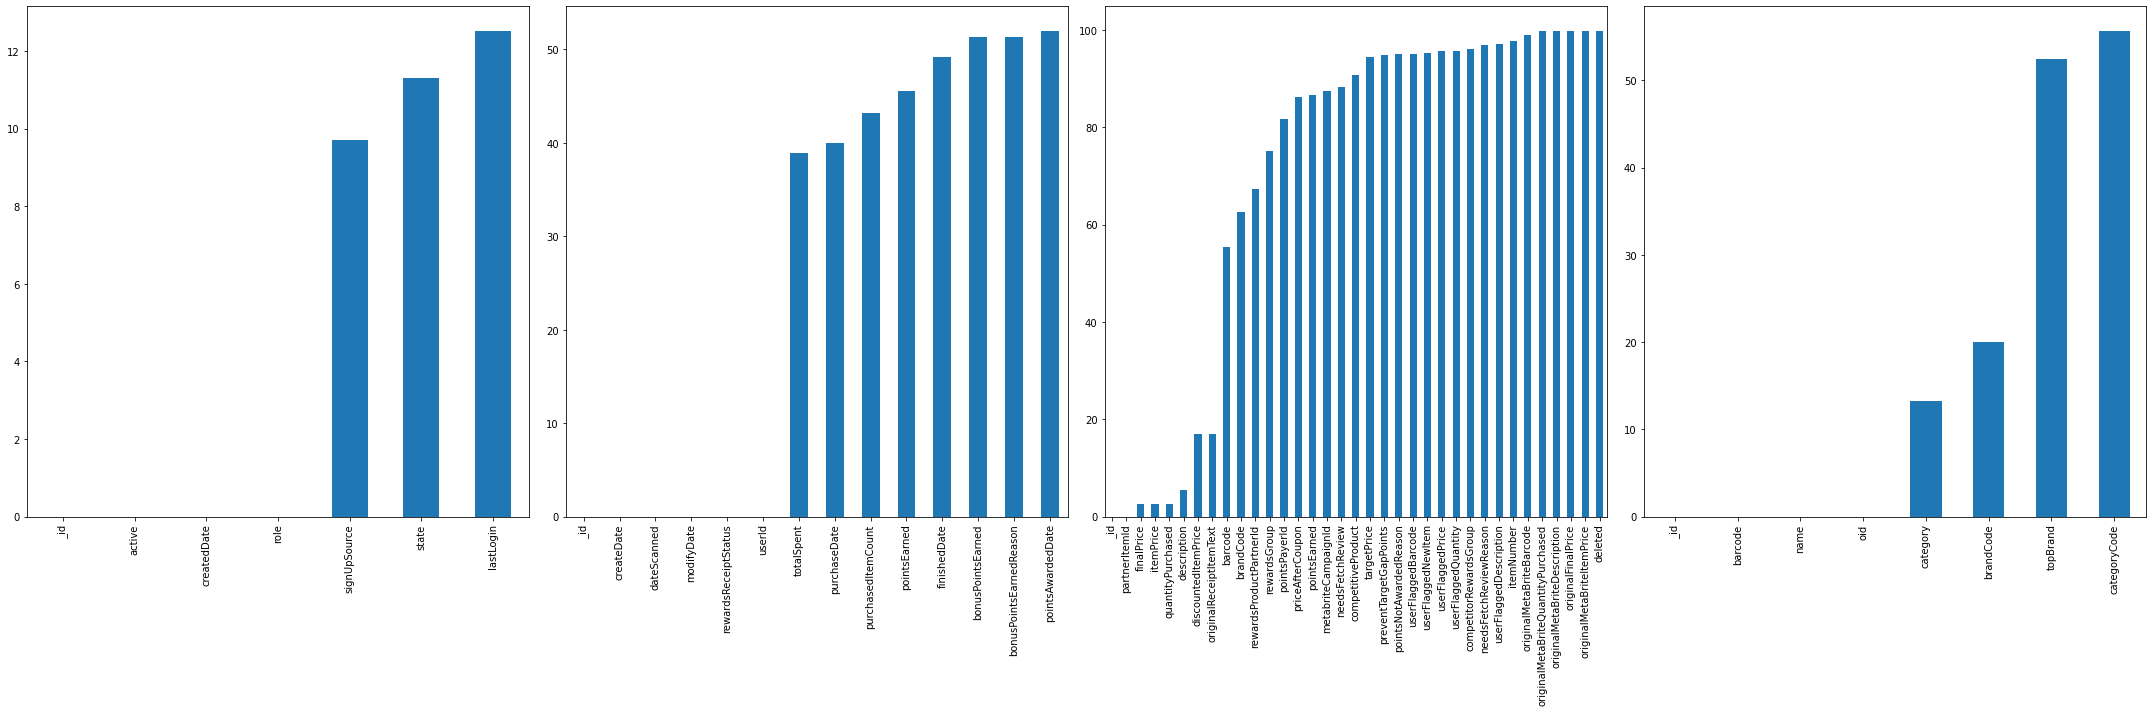

In [113]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [30,10]
plt.rcParams["figure.autolayout"] = True
fig, axes = plt.subplots(1, 4)

missing_percent_of_users = user.isnull().sum().sort_values(ascending= True)/len(user)*100
missing_percent_of_users.plot(kind='bar',ax=axes[0])

missing_percent_of_receipt = receipt.isnull().sum().sort_values(ascending= True)/len(receipt)*100
missing_percent_of_receipt.plot(kind='bar',ax=axes[1])

missing_percent_of_item = item.isnull().sum().sort_values(ascending= True)/len(item)*100
missing_percent_of_item.plot(kind='bar',ax=axes[2])

missing_percent_of_brand = brand.isnull().sum().sort_values(ascending= True)/len(brand)*100
missing_percent_of_brand.plot(kind='bar',ax=axes[3])

plt.show()

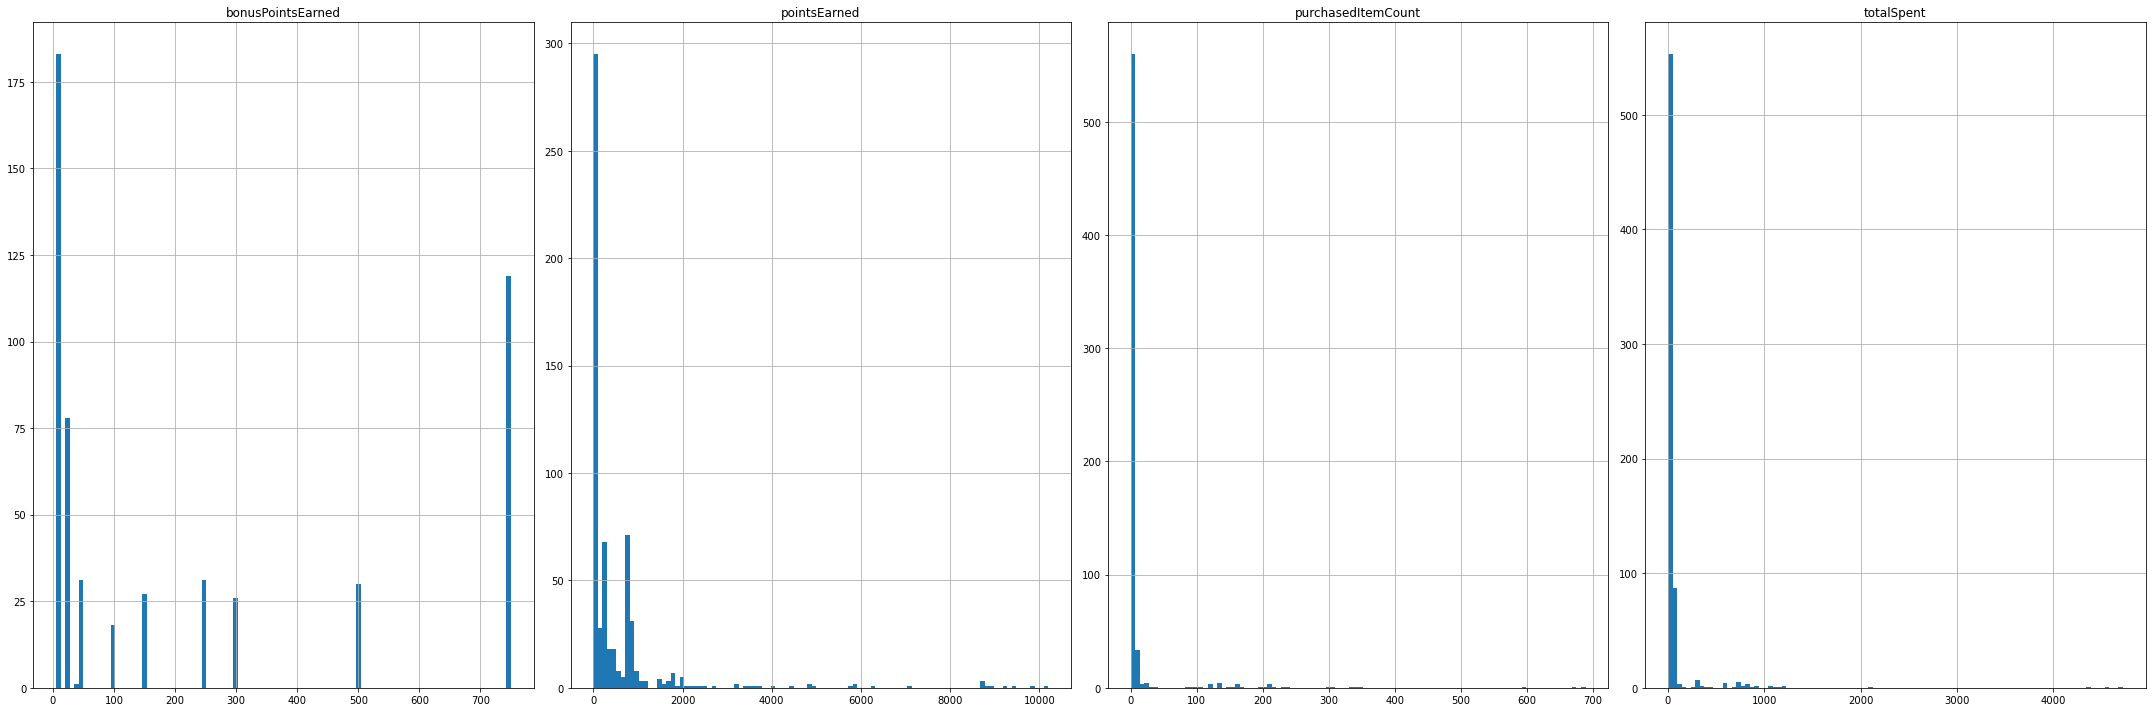

In [115]:
plt.rcParams["figure.figsize"] = [30, 10]
plt.rcParams["figure.autolayout"] = True

fig, axes = plt.subplots(1, 4)

receipt.hist('bonusPointsEarned', bins=100, ax=axes[0])
receipt.hist('pointsEarned', bins=100, ax=axes[1])
receipt.hist('purchasedItemCount', bins=100, ax=axes[2])
receipt.hist('totalSpent', bins=100, ax=axes[3])

plt.show()

# Based on the second level of quality check, the following insights are found.

#####  1) All the four tables has nulls in most of the columns. The percentage of nulls is so high in item table. Why does few columns have null? Is there a business reason behind the existence of nulls? Can the nulls be removed?
#####  2) The distribution of pointsEarned,purchasedItemCount,totalSpent is right skewed. There exists outliers. Are these outliers due to error or are they special cases?